Credits to the Experts (Please like their kernels)<br>
Ashish Gupta: [24+ top lgbm models outputs](https://www.kaggle.com/roydatascience/lgmodels)<br>
Konstantin: [ieee-internal-blend](https://www.kaggle.com/kyakovlev/ieee-internal-blend)<br>

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob

from scipy.stats import describe
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# Stacking Approach using GMEAN

In [38]:
LABELS = ["isFraud"]
oof_trains = glob.glob('./outputs/oof_train/*.csv')
oof_tests = glob.glob('./outputs/oof_test/*.csv')

folder_path = './ieee-fraud-detection'
train_transaction = pd.read_csv(f'{folder_path}/train_transaction.csv')
#test_transaction = pd.read_csv(f'{folder_path}/test_transaction.csv')
sample_sub = pd.read_csv(f'{folder_path}/sample_submission.csv')
y = train_transaction.sort_values('TransactionDT')['isFraud'].astype(bool)

In [4]:
oof_trains

['./outputs/oof_train/oof_train_2019-09-16.csv',
 './outputs/oof_train/oof_train_2019-09-11_5.csv',
 './outputs/oof_train/oof_train_2019-09-14.csv',
 './outputs/oof_train/oof_train_2019-09-11_4.csv',
 './outputs/oof_train/oof_train_2019-09-11.csv',
 './outputs/oof_train/oof_train_2019-09-10.csv',
 './outputs/oof_train/oof_train_2019-09-12.csv',
 './outputs/oof_train/oof_train_2019-09-11_3.csv',
 './outputs/oof_train/oof_train_2019-09-08_2.csv',
 './outputs/oof_train/oof_train_2019-09-11_2.csv',
 './outputs/oof_train/oof_train_2019-09-16_3.csv',
 './outputs/oof_train/oof_train_2019-09-16_2.csv',
 './outputs/oof_train/oof_train_2019-09-16_0.9213.csv',
 './outputs/oof_train/oof_train_2019-09-16_5.csv',
 './outputs/oof_train/oof_train_2019-09-16_4.csv',
 './outputs/oof_train/oof_train_2019-09-16_0.9215.csv',
 './outputs/oof_train/oof_train_2019-09-12_smirnov0.05.csv',
 './outputs/oof_train/oof_train_2019-09-27_0.9238.csv',
 './outputs/oof_train/oof_train_baseline.csv',
 './outputs/oof_trai

In [33]:
S_train = [pd.read_csv(oof_trains[f], index_col=0) for f in range(len(oof_trains))]
S_train = pd.concat(S_train, axis=1)
S_test = [pd.read_csv(oof_tests[f], index_col=0) for f in range(len(oof_tests))]
S_test = pd.concat(S_test, axis=1)
cols = list(map(lambda x: "m" + str(x), range(len(S_train.columns))))
S_train.columns = cols
S_test.columns = cols

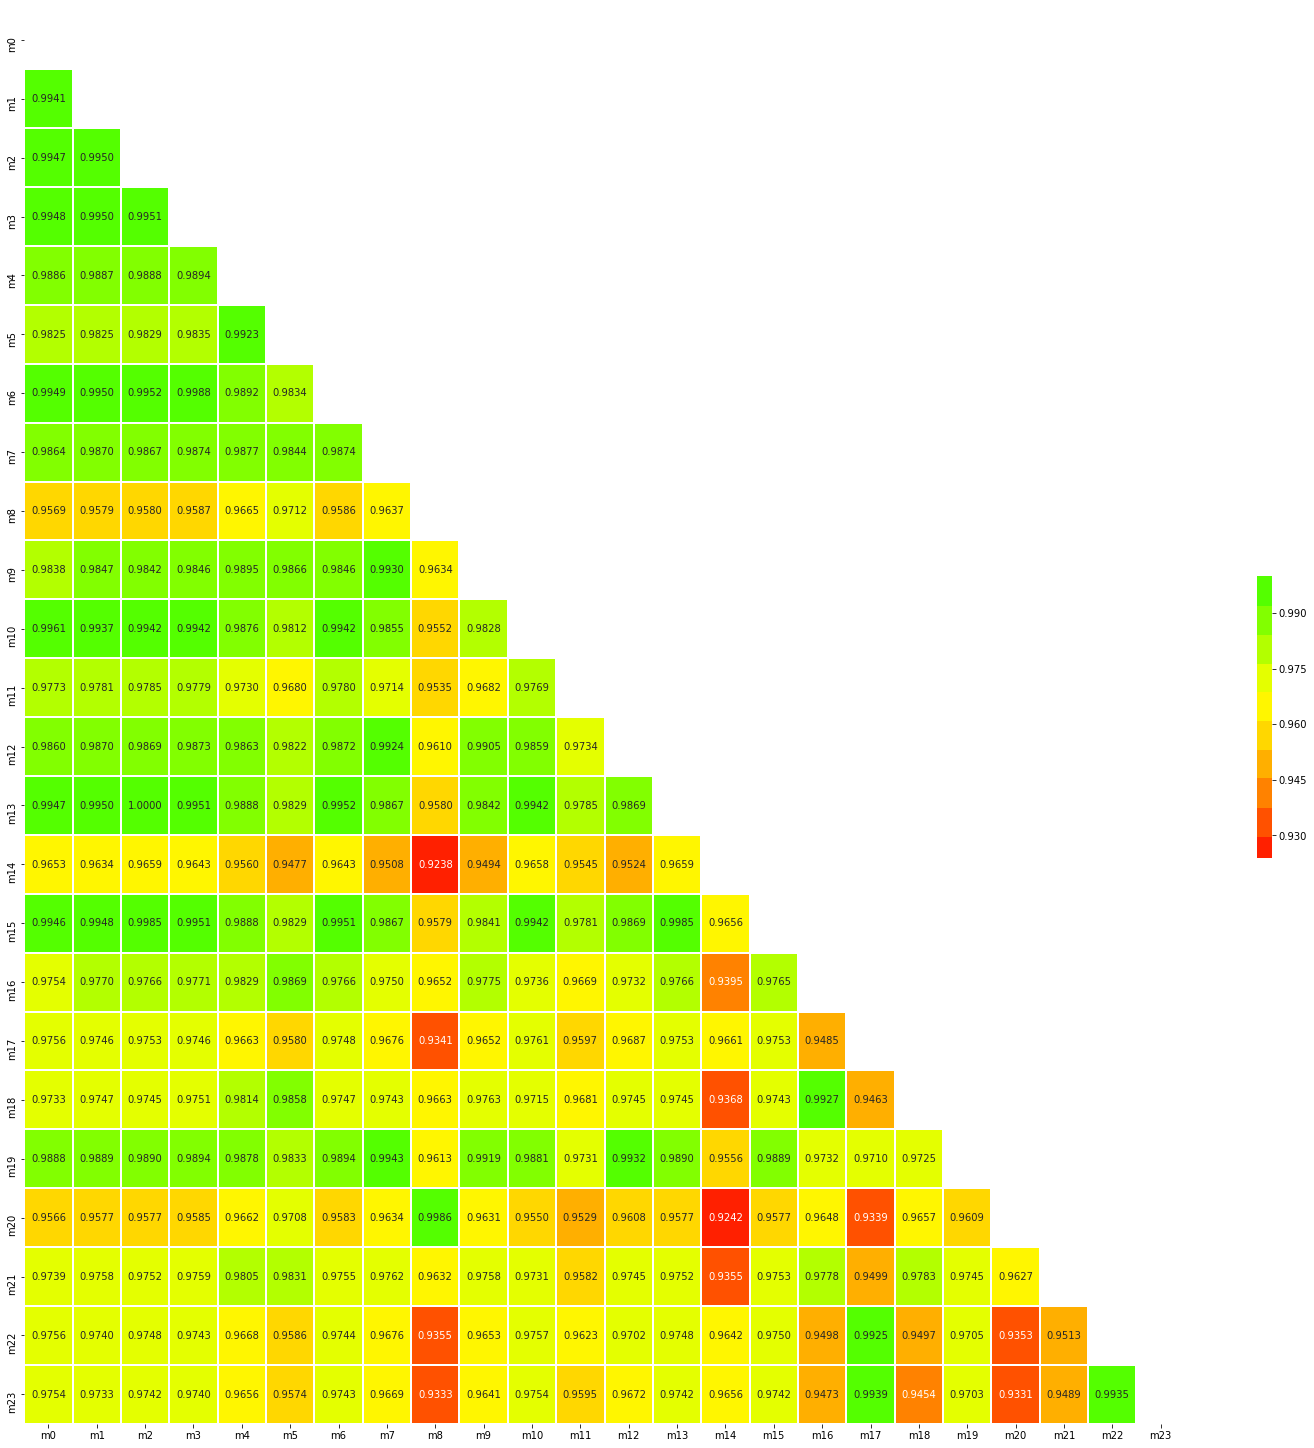

In [16]:
# check correlation
corr_train = S_train.corr()
mask = np.zeros_like(corr_train, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr_train,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

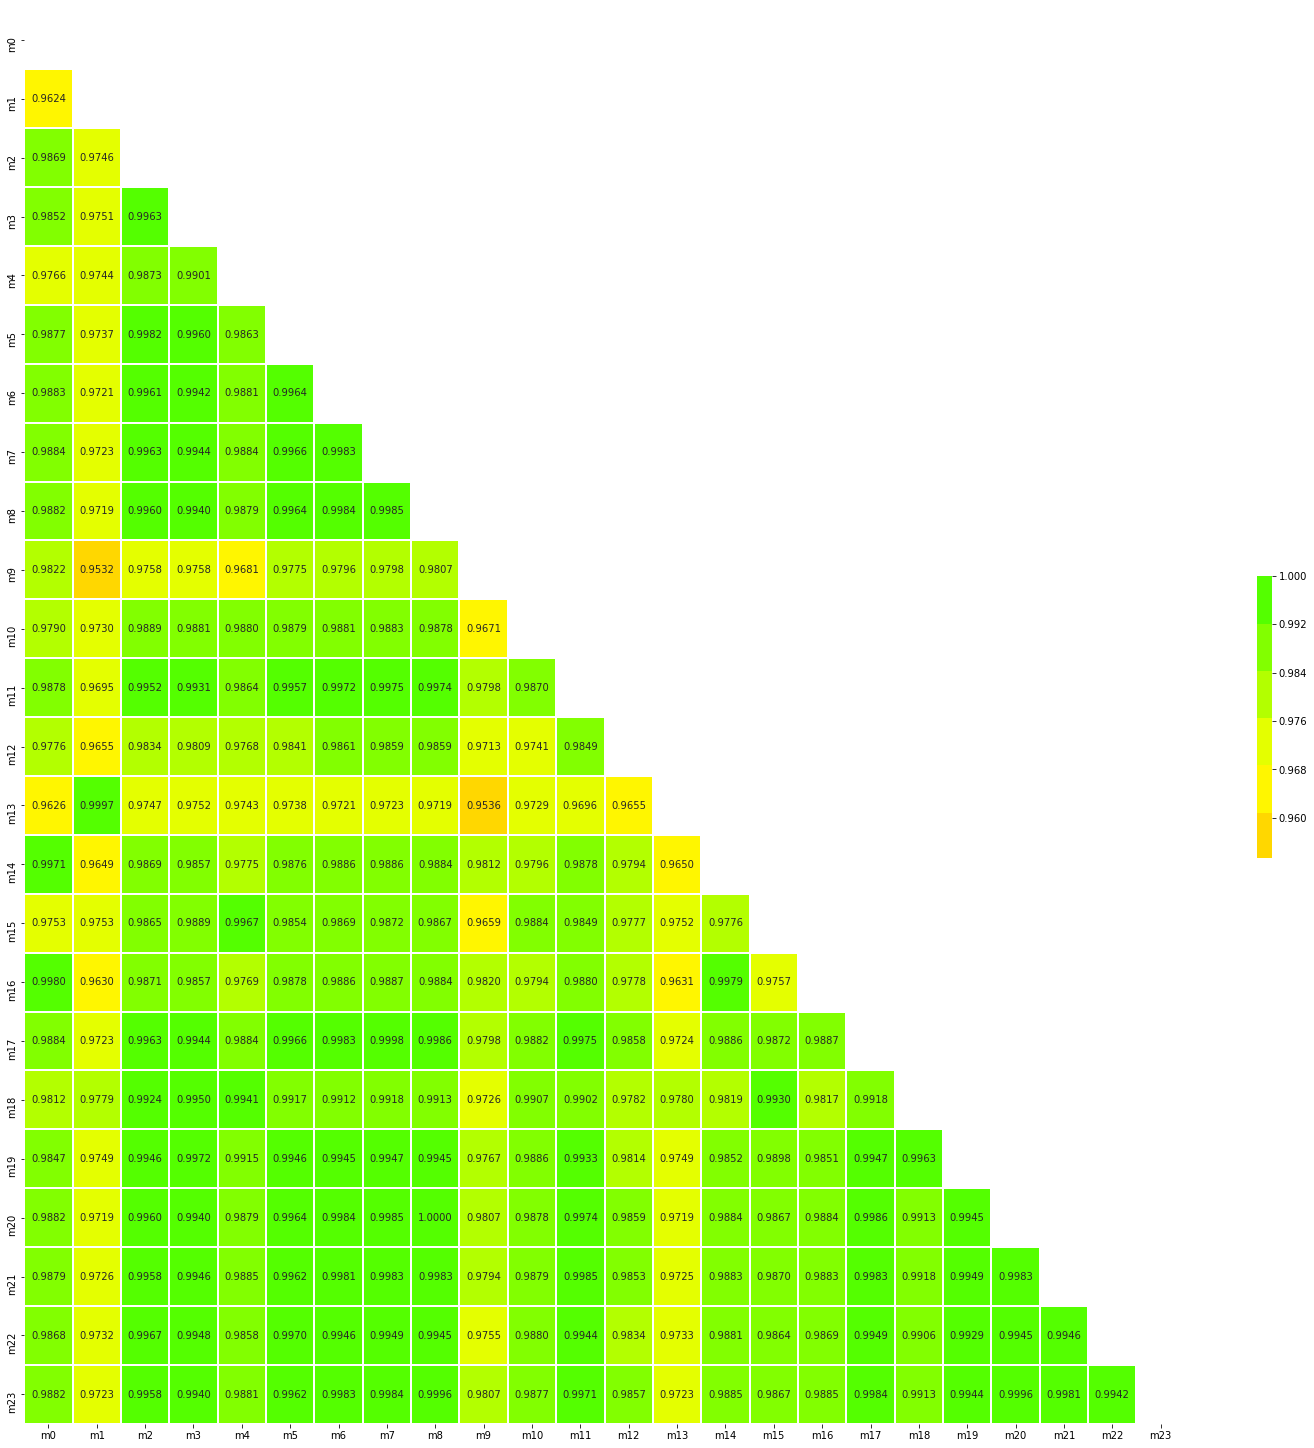

In [17]:
# check correlation
corr_test = S_test.corr()
mask = np.zeros_like(corr_test, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr_test,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

# Select models with low average correlation

In [19]:
mean_corr_train = corr_train.mean()
mean_corr_train = mean_corr_train.sort_values(ascending=True)
mean_corr_train = mean_corr_train[:6]
mean_corr_train

m14    0.955943
m20    0.958986
m8     0.959243
m23    0.966967
m17    0.967643
m22    0.967992
dtype: float64

In [20]:
mean_corr_test = corr_test.mean()
mean_corr_test = mean_corr_test.sort_values(ascending=True)
mean_corr_test = mean_corr_test[:6]
mean_corr_test

m1     0.973156
m13    0.973212
m9     0.975792
m12    0.980950
m0     0.984529
m15    0.984629
dtype: float64

In [34]:
model_selected_train = [0, 4, 7, 11, 14, 16, 20, 21, 23]
model_selected_test = [0, 1, 2, 9, 10, 12, 15]

S_train_BasedOnTrain = S_train.iloc[:, model_selected_train]
S_test_BasedOnTrain = S_test.iloc[:, model_selected_train]

S_train_BasedOnTest = S_train.iloc[:, model_selected_test]
S_test_BasedOnTest = S_test.iloc[:, model_selected_test]

# Stacking

In [35]:
result_train = cross_val_score(LogisticRegression(), S_train_BasedOnTrain, y, cv=5, scoring='roc_auc')
result_test = cross_val_score(LogisticRegression(), S_train_BasedOnTest, y, cv=5, scoring='roc_auc')

In [36]:
print('Stacker_train score: %.5f' % (result_train.mean()))
print('Stacker_test score: %.5f' % (result_test.mean()))

Stacker_train score: 0.87415
Stacker_test score: 0.87009


In [40]:
clf_train = LogisticRegression()
clf_train.fit(S_train_BasedOnTrain, y)
res_train = clf_train.predict_proba(S_test_BasedOnTrain)[:, 1]

clf_test = LogisticRegression()
clf_test.fit(S_train_BasedOnTest, y)
res_test = clf_test.predict_proba(S_test_BasedOnTest)[:, 1]

In [37]:
import datetime
today = str(datetime.date.today())

In [41]:
submission_train = sample_sub.copy()
submission_train['isFraud'] = res_train
submission_train.to_csv(f'./outputs/ensemble/Stacking_train_{today}_{result_train.mean():.4f}.csv', index=False)

In [42]:
submission_test = sample_sub.copy()
submission_test['isFraud'] = res_test
submission_test.to_csv(f'./outputs/ensemble/Stacking_test_{today}_{result_test.mean():.4f}.csv', index=False)

In [15]:
concat_sub['isFraud'] = m_gmean
concat_sub[['isFraud']].to_csv(f'./outputs/ensemble/stack_gmean_{today}.csv')